In [1]:
import os
import sys

# Set working directory
plant_clef_root = '/home/ffw/workspace/plantCLEF/'
os.chdir(plant_clef_root)

data_dir = os.path.join(plant_clef_root, 'data')

import numpy as np
import sklearn
import scipy
import scipy.misc
import time
import logging
import tempfile
import pprint

import matplotlib.pyplot as plt
%matplotlib inline

from utilities import *
import mcl

import caffe
from caffe import layers as L
from caffe import params as P
caffe.set_mode_gpu()

import mcl.solvers as mcl_solvers
import mcl.nets.scatnet_net
reload(mcl.nets.scatnet_net)
from mcl.nets.scatnet_net import scatnet, gen_prototxt, get_layers_sizes


/home/ffw/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
log_file_path = os.path.join(plant_clef_root, 'data', 'scattering_transfer.log')


logger = logging.getLogger('ScatnetTransform')
logger.setLevel(logging.INFO)

fh = logging.FileHandler(log_file_path)
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s:%(levelname)s: %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

print log_file_path


/home/ffw/workspace/plantCLEF/data/scattering_transfer.log


In [3]:
train_data_path = os.path.join(plant_clef_root, 'data', 'train.txt')
test_data_path = os.path.join(plant_clef_root, 'data', 'test.txt')

train_output_folder = os.path.join(plant_clef_root, 'data', 'train_scat')
test_output_folder = os.path.join(plant_clef_root, 'data', 'test_scat')

mean_output_path = os.path.join(plant_clef_root, 'scat_mean.npy')
mean_output = scipy.load(mean_output_path)

shape = (375, 47, 47)
dtype = 'float32'
scats = !ls $train_output_folder



# Produce test net

In [4]:
weight_param = dict(lr_mult=1, decay_mult=1)
bias_param = dict(lr_mult=2, decay_mult=0)
learned_param = [weight_param, bias_param]

def fc_relu(bottom, nout, param=learned_param,
            weight_filler=dict(type='gaussian', std=0.005).copy(),
            bias_filler=dict(type='constant', value=0.1).copy()):
    fc = L.InnerProduct(bottom, num_output=nout, param=param,
                        weight_filler=weight_filler,
                        bias_filler=bias_filler)
    return fc, L.ReLU(fc, in_place=True)

def classifier(data, label, classifier_name, num_classes, train=False, output_path=None):    
    n = caffe.NetSpec()
    n.data = data
    
    weight_filler=dict(type='gaussian', std=0.005)
    bias_filler=dict(type='constant', value=0.1)
    
    n.pool = L.Pooling(n.data, pool=P.Pooling.MAX, kernel_size=11, stride=10)
    
    n.fc6, n.relu6 = fc_relu(n.pool, 4096, param=learned_param)
    if train:
        n.drop6 = fc7input = L.Dropout(n.relu6, in_place=True)
    else:
        fc7input = n.relu6
        
    fc8 = L.InnerProduct(fc7input, num_output=num_classes, param=learned_param,
                        weight_filler=weight_filler,
                        bias_filler=bias_filler)    
    n.__setattr__(classifier_name, fc8)
    if not train:
        n.probs = L.Softmax(fc8)
    if label is not None:
        n.label = label
        n.loss = L.SoftmaxWithLoss(fc8, n.label)
        n.acc = L.Accuracy(fc8, n.label)
    # write the net to a temporary file and return its filename
    if output_path:
        with open(output_path, 'w+') as f:
            f.write(str(n.to_proto()))
            return f.name
    else:
        with tempfile.NamedTemporaryFile(delete=False) as f:
            f.write(str(n.to_proto()))
            return f.name


In [5]:
BATCH_SIZE = 32

L.Data()

data_layer = L.Data(
    batch_size=BATCH_SIZE, 
    backend=P.Data.LMDB, 
    source='/home/ffw/workspace/plantCLEF/data/train_lmdb_data',
    ntop=1)

label_layer = L.Data(
    batch_size=BATCH_SIZE, 
    backend=P.Data.LMDB, 
    source='/home/ffw/workspace/plantCLEF/data/train_lmdb_labels/',
    ntop=1)
'''
data_layer, label_layer = L.Data(
    batch_size=BATCH_SIZE, 
    backend=P.Data.LMDB, 
    source='/home/ffw/workspace/plantCLEF/data/train_lmdb_data/',
    ntop=2)
'''





proto_file = classifier(data_layer, label_layer, classifier_name='scatnet_ffnn', num_classes=967, train=True, output_path="/home/ffw/transfer.prototxt")
!cat $proto_file

layer {
  name: "data"
  type: "Data"
  top: "data"
  data_param {
    source: "/home/ffw/workspace/plantCLEF/data/train_lmdb_data"
    batch_size: 32
    backend: LMDB
  }
}
layer {
  name: "pool"
  type: "Pooling"
  bottom: "data"
  top: "pool"
  pooling_param {
    pool: MAX
    kernel_size: 11
    stride: 10
  }
}
layer {
  name: "fc6"
  type: "InnerProduct"
  bottom: "pool"
  top: "fc6"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  inner_product_param {
    num_output: 4096
    weight_filler {
      type: "gaussian"
      std: 0.005
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu6"
  type: "ReLU"
  bottom: "fc6"
  top: "fc6"
}
layer {
  name: "drop6"
  type: "Dropout"
  bottom: "fc6"
  top: "fc6"
}
layer {
  name: "scatnet_ffnn"
  type: "InnerProduct"
  bottom: "fc6"
  top: "scatnet_ffnn"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
 

In [6]:
if 'net' in locals():
    del net
net = caffe.Net(proto_file, caffe.TRAIN)

p_sum = 0
for p in net.params.values():
    for pp in p:        
        p_sum += np.prod(pp.data.shape)

print "There are %i parameters. (%.1fMB)" % (p_sum, p_sum * 4 * 2**-20)


There are 42365895 parameters. (161.6MB)


In [7]:
%time
net.forward();

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.1 µs


In [8]:
net.blobs.keys()

['data',
 'pool',
 'fc6',
 'scatnet_ffnn',
 'scatnet_ffnn_scatnet_ffnn_0_split_0',
 'scatnet_ffnn_scatnet_ffnn_0_split_1',
 'label',
 'label_label_0_split_0',
 'label_label_0_split_1',
 'loss',
 'acc']

In [9]:
scale = 3
scales = 2**np.arange(0,scale)
max_order = 3
nangles = 4
filter_size_factor = 2

def show_output(net, indx=0, blob_key='data'):
    output = np.squeeze(net.blobs[blob_key].data[indx,:,:,:])
    tmp = output[:,::,::,np.newaxis].copy()
    mask = get_layers_sizes(nangles, max_order, scales, nchannels_input=3)
    tmp = np.concatenate([tmp[mask==0],tmp[mask==1],tmp[mask==2]],3)
    vis_square(1-(tmp[0:,:,:,::-1]))

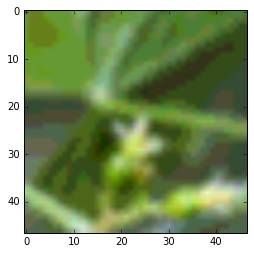

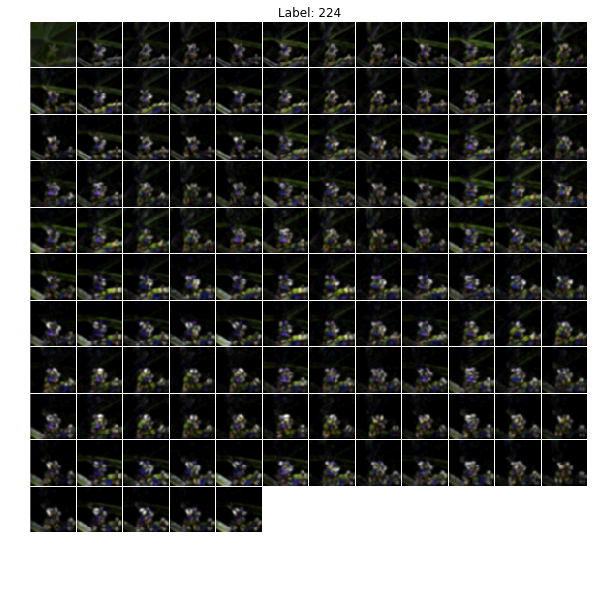

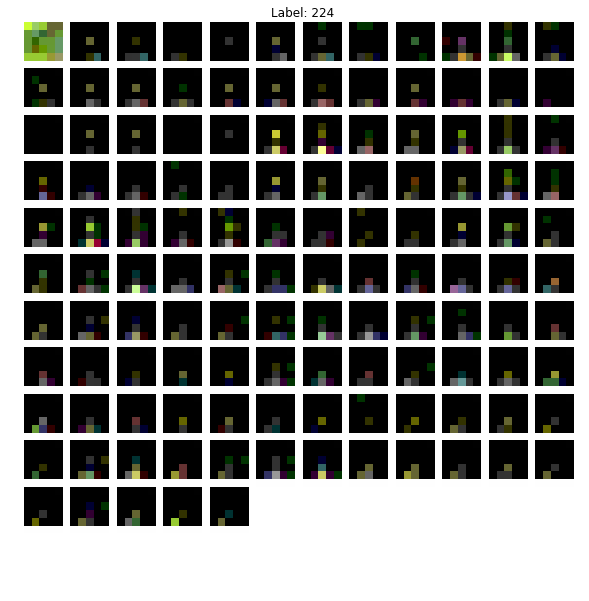

In [13]:
# Index 6 is image 100025.jpg
select_index = 19

img = net.blobs['data'].data[select_index,0:3,...].transpose([1,2,0]).copy()
img = -img[:,:,::-1]
img -= img.min()
img /= img.max()
plt.imshow(img[:,:,:])

figsize=(10,10)

plt.figure(figsize=figsize)
plt.title("Label: %.0f"%net.blobs['label'].data[select_index])
show_output(net, select_index)

plt.figure(figsize=figsize)
plt.title("Label: %.0f"%net.blobs['label'].data[select_index])
show_output(net, select_index,blob_key='pool')

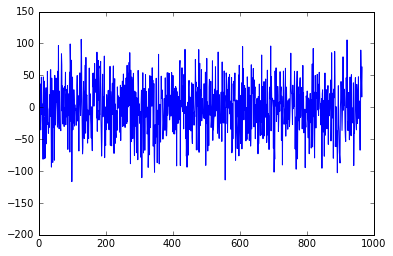

In [12]:
plt.plot(net.blobs['scatnet_ffnn'].data[select_index,:])

In [17]:
%time
net.backward();
net.blobs

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.8 µs


OrderedDict([('data', <caffe._caffe.Blob at 0x7f1ea6ca0050>),
             ('pool', <caffe._caffe.Blob at 0x7f1ea6ca00c8>),
             ('fc6', <caffe._caffe.Blob at 0x7f1ea6ca0140>),
             ('scatnet_ffnn', <caffe._caffe.Blob at 0x7f1ea6ca01b8>),
             ('scatnet_ffnn_scatnet_ffnn_0_split_0',
              <caffe._caffe.Blob at 0x7f1ea6ca0230>),
             ('scatnet_ffnn_scatnet_ffnn_0_split_1',
              <caffe._caffe.Blob at 0x7f1ea6ca02a8>),
             ('label', <caffe._caffe.Blob at 0x7f1ea6ca0320>),
             ('label_label_0_split_0', <caffe._caffe.Blob at 0x7f1ea6ca0398>),
             ('label_label_0_split_1', <caffe._caffe.Blob at 0x7f1ea6ca0410>),
             ('loss', <caffe._caffe.Blob at 0x7f1ea6ca0488>),
             ('acc', <caffe._caffe.Blob at 0x7f1ea6ca0500>)])

In [33]:
del net

In [8]:
style_solver_filename = mcl_solvers.tutorial(proto_file, base_lr=0.01)
style_solver = caffe.get_solver(style_solver_filename)

In [9]:
def run_solvers(niter, solvers, disp_interval=1000):
    """Run solvers for niter iterations,
       returning the loss and accuracy recorded each iteration.
       `solvers` is a list of (name, solver) tuples."""
    blobs = ('loss', 'acc')
    loss, acc = ({name: np.zeros(niter) for name, _ in solvers}
                 for _ in blobs)
    for it in range(niter):
        for name, s in solvers:
            s.step(1)  # run a single SGD step in Caffe
            loss[name][it], acc[name][it] = (s.net.blobs[b].data.copy()
                                             for b in blobs)
        if it % disp_interval == 0 or it + 1 == niter:
            loss_disp = '; '.join('%s: loss=%.3f, acc=%2d%%' %
                                  (n, loss[n][it], np.round(100*acc[n][it]))
                                  for n, _ in solvers)
            print '%3d) %s' % (it, loss_disp)     
    # Save the learned weights from both nets.
    weight_dir = tempfile.mkdtemp()
    weights = {}
    for name, s in solvers:
        filename = 'weights.%s.caffemodel' % name
        weights[name] = os.path.join(weight_dir, filename)
        s.net.save(weights[name])
    return loss, acc, weights

In [10]:
loss, acc, weights = run_solvers(200, [('scat_net', style_solver)], disp_interval=20);

  0) scat_net: loss=6.908, acc= 0%
 20) scat_net: loss=6.906, acc= 0%
 40) scat_net: loss=6.904, acc= 0%
 60) scat_net: loss=6.902, acc= 0%
 80) scat_net: loss=6.907, acc= 0%
100) scat_net: loss=6.898, acc= 0%
120) scat_net: loss=6.916, acc= 3%
140) scat_net: loss=6.887, acc= 0%
160) scat_net: loss=6.893, acc= 3%
180) scat_net: loss=6.881, acc= 0%
199) scat_net: loss=6.893, acc= 0%


In [11]:
np.diff(loss['scat_net'])

array([  8.04287925e+01,  -2.72926331e+00,   2.72926331e+00,
        -4.27278061e+01,  -3.77010570e+01,   5.52177429e-04,
         2.51242876e+00,  -2.50365973e+00,   2.48456492e+01,
        -2.48554239e+01,   4.76837158e-05,  -6.74247742e-04,
         6.99996948e-04,  -2.00271606e-04,   1.20162964e-04,
        -1.82342529e-03,   5.05447388e-05,   1.13159657e-01,
         1.27326951e+01,  -1.28452435e+01,   9.17434692e-04,
         2.14576721e-03,  -2.30979919e-03,  -1.67226791e-03,
        -3.70025635e-04,   2.07042694e-03,  -2.87294388e-03,
         1.43241882e-03,   2.96497345e-03,  -1.18207932e-03,
        -4.78267670e-04,  -2.29883194e-03,   4.95433807e-04,
         2.51287270e+00,   7.79187698e+01,  -8.04333944e+01,
         6.26945496e-03,  -4.65488434e-03,   1.04379654e-03,
        -1.88875198e-03,   2.48241425e-03,   6.32095337e-03,
        -4.13703918e-03,  -5.04112244e-03,   9.68141556e-01,
         7.94648581e+01,  -8.04327221e+01,   3.84044647e-03,
        -5.04207611e-03,

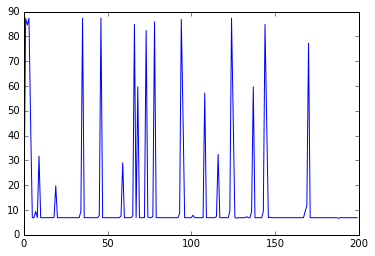

In [17]:
plt.plot(loss['scat_net'])

NameError: name 'net' is not defined

# Manuel injection


#data_layer = L.Input(shape=dict(dim=[BATCH_SIZE] + list(shape)))
#data_layer = L.Input(shape=dict(dim=[1] + shape_reduced))
#label_layer = L.Input(shape=dict(dim=[BATCH_SIZE, 1]))

%%time
#s = np.fromfile(os.path.join(train_output_folder, scats[0]), dtype='float32').reshape(shape)
#net.blobs['data'].data[...] = normalize(s[:,:,:])
#net.blobs['label'].data[...] = 54
#net.blobs['data'].data[...] = normalize(s[:,::4,::4])
r = net.forward()

v = net.blobs['loss'].data


batch_size = BATCH_SIZE
for k, l in labels.items():
    batch_size -= 1
    scat_path = os.path.join(train_output_folder, "%s.scat" % k)    
    s = np.fromfile(scat_path, dtype='float32').reshape(shape)
    print scat_path, l    
    net.blobs['data'].data[batch_size,...] = normalize(s[:,:,:])
    net.blobs['label'].data[batch_size,...] = float(l)
    
    if batch_size < 0:
        net.forward_backward_all()
        loss = net.blobs['loss'].data
        batch_size = BATCH_SIZE
        break

loss

np.sum(rb['data'].data)

p = np.squeeze(net.blobs['data'].data)

p.shape

plt.figure(figsize=(8,8))
show_output(p[2,...], 4, 3, range(4), norm_input=False)

t0 = time.time()
s = None
for i in range(100):
    d = np.fromfile(os.path.join(train_output_folder, scats[i]), dtype='float32').reshape(shape)
    d = normalize(d)
    net.blobs['data'].data[...] = d[]
    net.forward()
    if s is None:
        s = d
    else:
        s += d
    
print 1000*(time.time() - t0) / 100

print 375 * 47**2 * 4 * 2**-20

print 256 * 13**2 * 4 * 2**-20

print 2048 * 13**2 * 4 * 2**-20

2**20

In [1]:
import argparse

In [4]:
parser = argparse.ArgumentParser()
parser.add_argument('test');
parser.add_argument('-k', default=4);

In [9]:
n = parser.parse_args("test -k 34".split())

In [19]:
def foo(*args ,**kwargs):
    print args
    print kwargs

foo(**vars(n))

()
{'test': 'test', 'k': '34'}
